# ChArUco

- ref: https://github.com/kyle-bersani/opencv-examples
- don't use digital smoothing!

- `ffmpeg -i _back.mp4 -vf "crop=w=1440:h=1920:x=1440:y=0, transpose=2" back.mp4`
- `ffmpeg -i main.mp4 -map 0 -c copy -f segment -segment_time 60 -reset_timestamps 1 main_%03d.mp4`
- `python get_intrinsics.py --vid ../data/record3d/tonpy-v8/raw/back.mp4 --squares 10 7`

In [17]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm import tqdm
import pickle

from utils import undistort


aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
charuco = aruco.CharucoBoard_create(
        squaresX=10,
        squaresY=7,
        squareLength=0.039,
        markerLength=0.0195,
        dictionary=aruco_dict)

In [18]:
with open('camera_raw.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)

vid = imageio.mimread("../data/record3d/tonpy-v8/raw/main_000.mp4", memtest=False)
vid = undistort(vid, mtx, dist)

with open('camera_undist.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:44<00:00, 44.84it/s]


In [19]:
vid_sample, vid_paint, rvec_hist, tvec_hist = [], [], [], []

for t, img in enumerate(vid[30:-30:3]):
    bak = deepcopy(img)
    img = deepcopy(img[...,::-1])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    aruco_params = aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = charuco,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = mtx,
            distCoeffs = dist)

    img = aruco.drawDetectedMarkers(img, corners, borderColor=(0, 0, 255), ids=ids)

    if not (ids is not None and len(ids) > 1):
        print("skip (t={}, ids={})".format(t, ids))
        continue

    response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=charuco)

    if response < 8:
        print("skip (t={}, response={})".format(t, response))
        continue

    # valid, rvec, tvec = aruco.estimatePoseCharucoBoard(
    #         charucoCorners=charuco_corners,
    #         charucoIds=charuco_ids,
    #         board=charuco, 
    #         cameraMatrix=mtx,
    #         distCoeffs=dist,
    #         rvec=None,
    #         tvec=None)
    
    objp = np.empty((0,3), np.float32)
    for idx in charuco_ids:
        objpi = np.dot(charuco.chessboardCorners[idx] - np.array([[5,7,0]]) * 0.04, np.array([[-1,0,0], [0,1,0], [0,0,-1]]))
        objp = np.append(objp, objpi, axis=0)

    valid, rvec, tvec = cv2.solvePnP(objp, charuco_corners, mtx, dist)

    if not valid:
        print("skip (t={}, valid={})".format(t, valid))
        continue

    img = cv2.drawFrameAxes(img, mtx, dist, rvec, tvec, 0.3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    vid_sample.append(bak)
    vid_paint.append(img)
    rvec_hist.append(rvec)
    tvec_hist.append(tvec)

print(len(vid_sample))
imageio.mimwrite("temp.mp4", vid_paint, macro_block_size=8)

skip (t=131, response=7)
skip (t=134, response=7)
skip (t=135, response=5)
skip (t=136, response=4)
skip (t=139, response=4)
skip (t=140, response=7)
skip (t=141, response=3)
skip (t=142, response=7)
skip (t=144, response=7)
skip (t=145, response=6)
skip (t=146, response=7)
skip (t=147, response=4)
skip (t=148, response=1)
skip (t=149, response=0)
skip (t=150, response=3)
skip (t=151, response=0)
skip (t=152, response=1)
skip (t=153, response=0)
skip (t=154, response=0)
skip (t=155, response=0)
skip (t=156, response=1)
skip (t=157, response=1)
skip (t=158, response=2)
skip (t=159, response=0)
skip (t=160, response=0)
skip (t=161, response=3)
skip (t=162, response=2)
skip (t=163, response=2)
skip (t=164, response=2)
skip (t=165, response=5)
skip (t=166, response=5)
skip (t=168, response=7)
skip (t=172, response=6)
skip (t=174, response=7)
skip (t=175, response=7)
skip (t=324, response=4)
skip (t=325, response=0)
skip (t=326, ids=[[5]])
skip (t=327, response=0)
skip (t=330, response=7)
s

In [21]:
with open('poses.pkl', 'wb') as f:
    pickle.dump((rvec_hist, tvec_hist), f)

In [85]:
imageio.mimwrite("src/main_real.mp4", vid_sample, macro_block_size=8)

In [86]:
w = 1920
h = 1440  # 1080

import os
import PIL
import json
import torch

# os.makedirs('images/', exist_ok=True)

out = {
    "fl_x": float(mtx[0,0]),
    "fl_y": float(mtx[1,1]),
    "cx": float(mtx[0,2]),
    "cy": float(mtx[1,2]),
    "w": w,
    "h": h,
    "camera_model": 'OPENCV',
    "k1": dist[0,0],
    "k2": dist[0,1],
    "p1": dist[0,2],
    "p2": dist[0,3],
}

poses = []
for t, (rvec, tvec) in enumerate(zip(rvec_hist, tvec_hist)):
    R, _ = cv2.Rodrigues(rvec)
    T = tvec

    c2w = np.eye(4)
    c2w[:3,3] = np.dot(R.T, - T).squeeze()
    c2w[:3,:3] = np.dot(R.T, np.array([[1,0,0], [0,-1,0], [0,0,-1]]))
    poses.append(c2w)


poses = torch.from_numpy(np.array(poses).astype(np.float32))
print(torch.max(torch.abs(poses[:, :3, 3])))


tensor(0.8383)


In [87]:
# scale_factor = 1.0
# scale_factor /= torch.max(torch.abs(poses[:, :3, 3]))
# print(scale_factor)
# poses[:, :3, 3] *= scale_factor * self.config.scale_factor

In [88]:
frames = []

for t, (img, c2w) in enumerate(zip(vid_sample, poses)):
    name = 'images/frame_{:05}.png'.format(t)
    # PIL.Image.fromarray(img).save(name, quality=95)  # heavy

    frame = {
        "file_path": name,
        "transform_matrix": c2w.tolist(),
    }
    frames.append(frame)

out["frames"] = frames

with open("transforms.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=4)

In [ ]:
len(frames)

In [1]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm.notebook import tqdm
import pickle
from utils import *

# size = (480, 360)
size = (960, 720)

In [2]:
back_real = imageio.mimread("src/back_real.mp4", memtest=False)
back_pred = imageio.mimread("src/back_pred.mp4", memtest=False)
print(len(back_real), back_real[0].shape, len(back_pred), back_pred[0].shape)

96 (1440, 1920, 3) 96 (360, 480, 3)


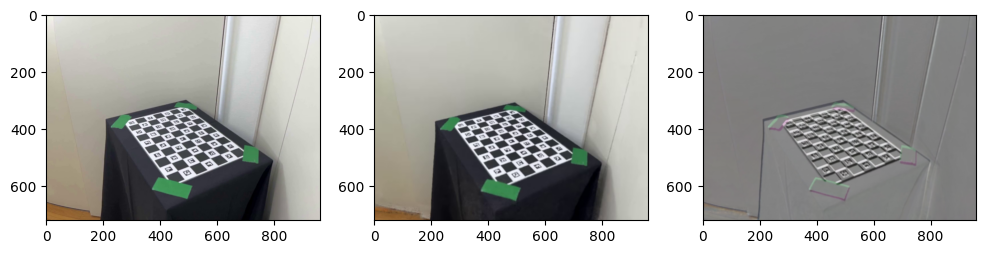

In [3]:
real = deepcopy(back_real[0])
pred = deepcopy(back_pred[0])
real = cv2.resize(real, size)
pred = cv2.resize(pred, size)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1); plt.imshow(real)
plt.subplot(1,3,2); plt.imshow(pred)

real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))
diff = real.astype(np.float32) - pred.astype(np.float32)
diff = (diff / 255. + 1.) / 2.

plt.subplot(1,3,3); plt.imshow(diff)
plt.show()

In [5]:
main_real = imageio.mimread("src/main_real.mp4", memtest=False)
main_pred = imageio.mimread("src/main_pred_d2.mp4", memtest=False)
print(len(main_real), main_real[0].shape, len(main_pred), main_pred[0].shape)

592 (1440, 1920, 3) 592 (720, 960, 3)


In [6]:
idx = 300

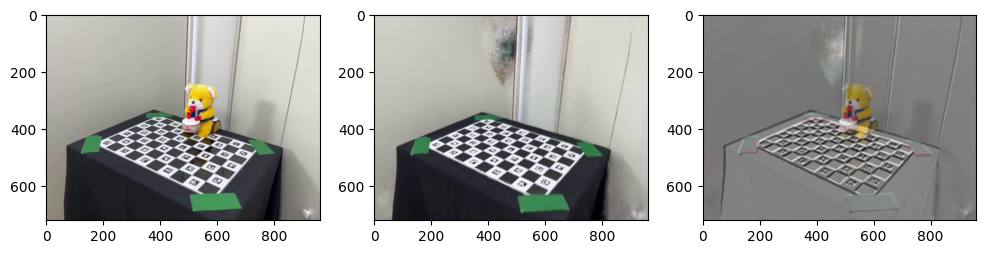

In [31]:
real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])
real = cv2.resize(real, size)
pred = cv2.resize(pred, size)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1); plt.imshow(real)
plt.subplot(1,3,2); plt.imshow(pred)

real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))
diff = real.astype(np.float32) - pred.astype(np.float32)
diff = (diff / 255. + 1.) / 2.

plt.subplot(1,3,3); plt.imshow(diff)
plt.show()

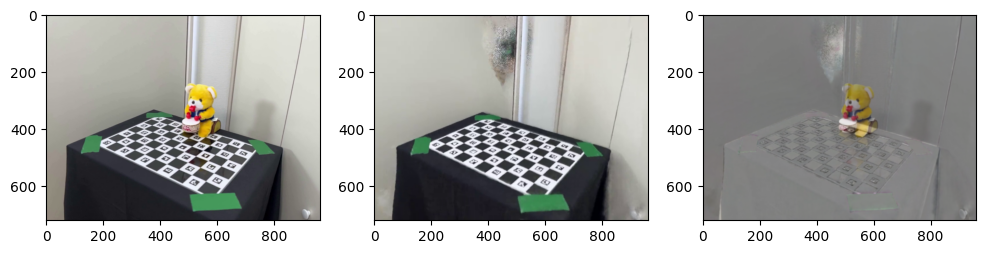

In [32]:
warper = Warper()

real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])
real = cv2.resize(real, size)
pred = cv2.resize(pred, size)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1); plt.imshow(real)
plt.subplot(1,3,2); plt.imshow(pred)

real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))

pred = warper(pred, real)

diff = real.astype(np.float32) - pred.astype(np.float32)
diff = (diff / 255. + 1.) / 2.

plt.subplot(1,3,3); plt.imshow(diff)
plt.show()

0.8156863 [0.28104573]


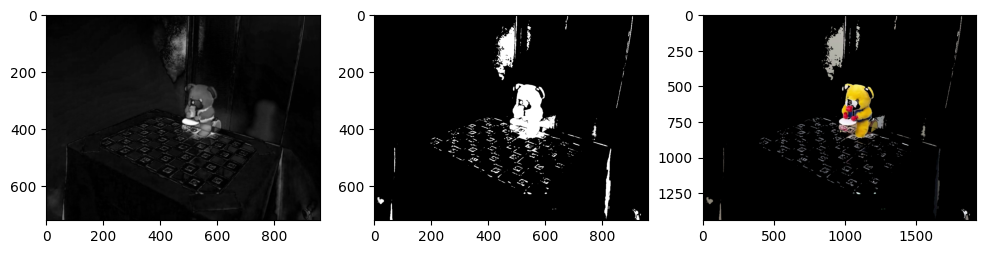

In [33]:
real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])

real = cv2.resize(real, size)
pred = cv2.resize(pred, size)
real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))
pred = warper(pred, real)

plt.figure(figsize=(12,12))

diff_rgb = real.astype(np.float32) - pred.astype(np.float32)
diff_rgb = np.mean(np.abs(diff_rgb), axis=2) / 255.
plt.subplot(1,3,1); plt.imshow(diff_rgb, cmap='gray')

print(diff_rgb.max(), np.percentile(diff_rgb, [98]))
thresh = 0.15  # threshより明るい => 問答無用で1
diff_rgb = np.clip(diff_rgb, 0, thresh) / thresh

diff_rgb = np.where(diff_rgb < 0.9, 0, diff_rgb)
plt.subplot(1,3,2); plt.imshow(diff_rgb, cmap='gray')

out = deepcopy(main_real[idx])/ 255.
diff_rgb = (diff_rgb.astype(np.float32) * 255).astype(np.uint8)
diff_rgb = cv2.resize(diff_rgb, out.shape[0:2][::-1])
out = out.astype(np.float32) * diff_rgb.astype(np.float32)[...,None] / 255.
plt.subplot(1,3,3); plt.imshow(out)
plt.show()

38.559944 [13.15940372]


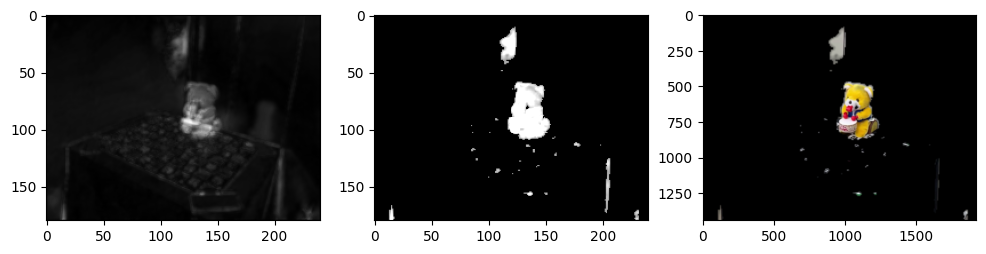

In [50]:
extractor = FeatureExtractor()

real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])

size = (960, 720)
real = cv2.resize(real, size)
pred = cv2.resize(pred, size)
real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))
pred = warper(pred, real)


real = extractor(real)
pred = extractor(pred)

plt.figure(figsize=(12,12))
diff_res = np.mean(np.abs(real - pred), axis=2)

plt.subplot(1,3,1); plt.imshow(diff_res, cmap='gray')

print(diff_res.max(), np.percentile(diff_res, [98]))
thresh = 12.  # threshより明るい => 問答無用で1
diff_res = np.clip(diff_res, 0, thresh) / thresh

diff_res = np.where(diff_res < 0.6, 0, diff_res)
plt.subplot(1,3,2); plt.imshow(diff_res, cmap='gray')

out = deepcopy(main_real[idx]) / 255.
diff_res = (diff_res.astype(np.float32) * 255).astype(np.uint8)
diff_res = cv2.resize(diff_res, out.shape[0:2][::-1])
out = out.astype(np.float32) * diff_res.astype(np.float32)[...,None] / 255.
plt.subplot(1,3,3); plt.imshow(out)
plt.show()

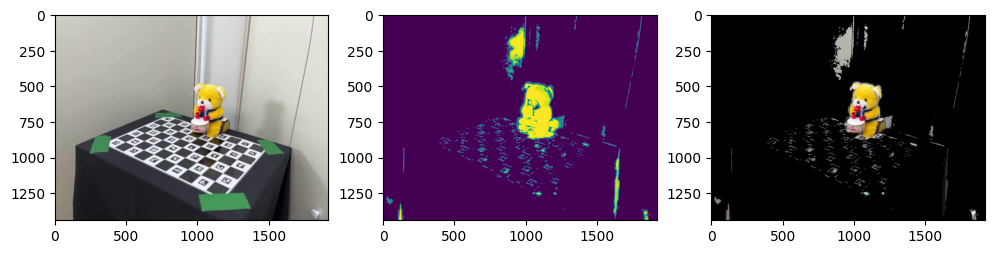

In [40]:
plt.figure(figsize=(12,12))

real = deepcopy(main_real[idx])
plt.subplot(1,3,1); plt.imshow(real)

diff = (diff_rgb.astype(np.float32) + diff_res.astype(np.float32)) / 255.
# diff = diff_res.astype(np.float32) / 255.
plt.subplot(1,3,2); plt.imshow(diff)

thresh = 1.  # threshより明るい => 問答無用で1
diff = np.clip(diff, 0, thresh) / thresh

# diff_res = np.where(diff_res < , 0, 1)
out = deepcopy(main_real[idx]) / 255.
out = out.astype(np.float32) * diff.astype(np.float32)[...,None]
plt.subplot(1,3,3); plt.imshow(out)
plt.show()

In [1]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm.notebook import tqdm
import pickle
from utils import *

# size = (480, 360)
size = (960, 720)


main_real = imageio.mimread("src/main_real.mp4", memtest=False)
main_pred = imageio.mimread("src/main_pred_d2.mp4", memtest=False)
print(len(main_real), main_real[0].shape, len(main_pred), main_pred[0].shape)

592 (1440, 1920, 3) 592 (720, 960, 3)


In [2]:
with open('camera_undist.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)
with open('poses.pkl', 'rb') as f:
    (rvec_hist, tvec_hist) = pickle.load(f)
print(len(rvec_hist), len(tvec_hist))

592 592


In [3]:
class BackRemover():
    def __init__(self):
        self.warper = Warper()
        self.extractor = FeatureExtractor()

    def __call__(self, real, pred, pts, upperlim=12., thresh=0.7, size=(960,720)):
        orig = deepcopy(real)
        
        real = cv2.resize(real, size)
        pred = cv2.resize(pred, size)
        real = cv2.blur(real, (3,3))
        pred = cv2.blur(pred, (3,3))
        pred = self.warper(pred, real)

        real = self.extractor(real)
        pred = self.extractor(pred)

        diff = np.mean(np.abs(real - pred), axis=2)

        # print(diff.max(), np.percentile(diff, [98]))
        diff = np.clip(diff, 0, upperlim) / upperlim

        diff = np.where(diff < thresh, 0, diff)

        segm = orig / 255.
        diff = (diff.astype(np.float32) * 255).astype(np.uint8)
        diff = cv2.resize(diff, segm.shape[0:2][::-1])
        
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
        diff = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel, iterations=7)
        diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel, iterations=7)

        mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY)[1]
        contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        mask = np.zeros(mask.shape[:2], dtype=np.uint8)
        for k, cnt in enumerate(contours):
            ret = cv2.pointPolygonTest(cnt, pts, False)
            if ret==1:
                mask = cv2.drawContours(mask, [cnt], 0, 255, -1)

        mask = (diff.astype(np.float32) / 255.) * (mask.astype(np.float32) / 255.)
        segm = segm.astype(np.float32) * mask.astype(np.float32)[...,None]
        segm = (segm * 255.).astype(np.uint8)
        return segm, mask

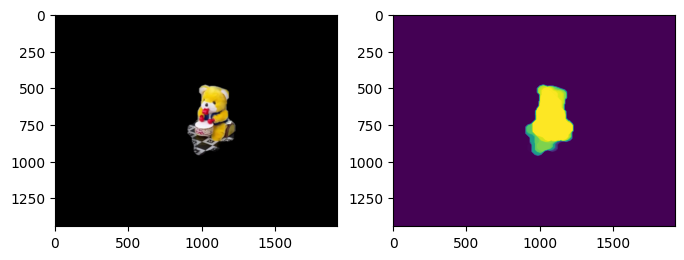

In [12]:
idx = 300

remover = BackRemover()

real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])

pts = np.float32([[0,0,0]])
rvec = rvec_hist[idx]
tvec = tvec_hist[idx]
pts = project_w2c(pts, rvec, tvec, mtx, dist)

segm, diff = remover(real, pred, pts, size=(1920,1440))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1); plt.imshow(segm)
plt.subplot(1,2,2); plt.imshow(diff)
plt.show()

In [7]:
# from tqdm.notebook import tqdm
# frames = []
# for real, pred, rvec, tvec in zip(tqdm(main_real[:100]), main_pred[:100], rvec_hist[:100], tvec_hist[:100]):
#     mpos_target = np.float32([[0,0,0]])
#     cpos_target = project_w2c(mpos_target, rvec, tvec, mtx, dist)

#     segm, diff = remover(real, pred, cpos_target, size=(1920,1440))
#     frames.append(segm)
# imageio.mimwrite("src/main_segm.mp4", frames, macro_block_size=8)

In [8]:
def crop(img, cpos_target, scale):
    W_crop, H_crop = 256, 256
    out = deepcopy(img)

    h, w = out.shape[:2]
    out = cv2.resize(out, (int(w * scale), int(h * scale)))

    cx, cy = (cpos_target * scale).squeeze().astype(np.int64).tolist()
    h, w = out.shape[:2]

    # padding for centering
    padx = w - cx * 2
    padx = (padx, 0) if padx > 0 else (0, -padx)
    pady = h - cy * 2
    pady = (pady, 0) if pady > 0 else (0, -pady)
    constant_values = [[(0,255,0),(0,255,0)], [(0,255,0),(0,255,0)], [0,0]]
    out = np.pad(out, [pady, padx, (0, 0)], 
                   'constant', constant_values=constant_values)
    out = np.pad(out, [(256, 256), (256, 256), (0, 0)], 
                   'constant', constant_values=constant_values)

    _h, _w = out.shape[:2]
    x0 = int(_w / 2 - W_crop / 2)
    y0 = int(_h / 2 - H_crop / 2)
    out = out[y0:y0+H_crop, x0:x0+W_crop]

    return out

  0%|          | 0/592 [00:00<?, ?it/s]

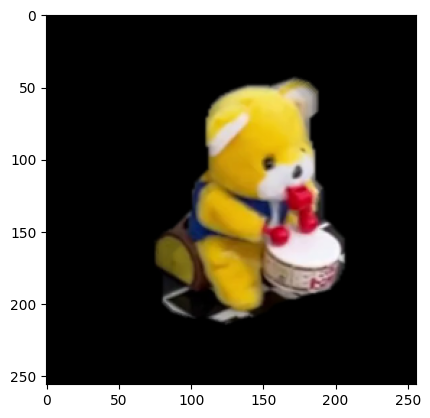

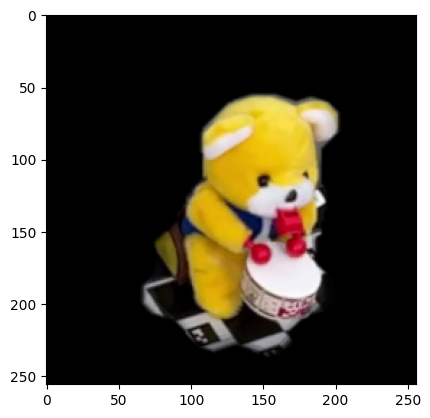

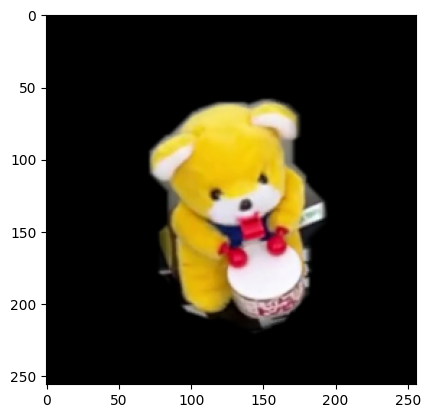

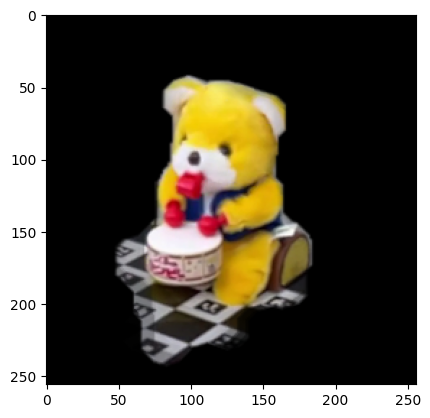

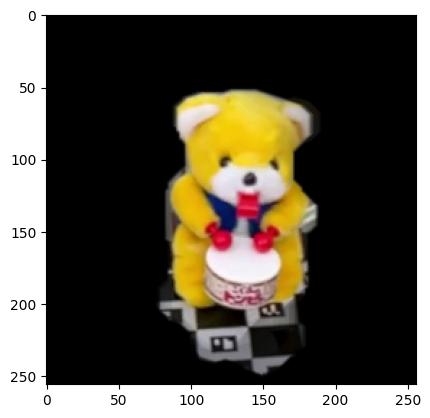

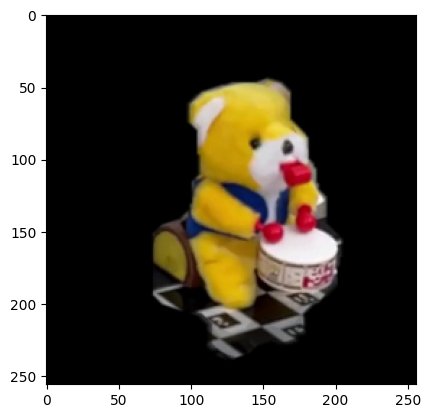

In [11]:
frames = []
views = []
scale = 0.5

for t, (real, pred, rvec, tvec) in enumerate(zip(tqdm(main_real), main_pred, rvec_hist, tvec_hist)):
    R, _ = cv2.Rodrigues(rvec)
    T = tvec

    c2w = np.eye(4)
    c2w[:3,3] = np.dot(R.T, - T).squeeze()
    c2w[:3,:3] = np.dot(R.T, np.array([[1,0,0], [0,-1,0], [0,0,-1]]))
    
    mpos_target = np.float32([[0,0,0.06]])
    cpos_target = project_w2c(mpos_target, rvec, tvec, mtx, dist)
    
    wpos_camera = c2w[:3,3].squeeze()
    wrot_camera = cv2.RQDecomp3x3(R.T)[0]

    segm, diff = remover(real, pred, cpos_target, size=(1920,1440))
    _scale = np.sum(wpos_camera**2)**0.5 * scale
    frame = crop(segm, cpos_target, _scale)
    if t % 100 == 0: plt.imshow(frame); plt.show()

    view = np.concatenate([wpos_camera, wrot_camera])

    frame = cv2.putText(frame, "t: {:04}".format(t), 
                (5, 15), cv2.FONT_HERSHEY_PLAIN, 
                1, (255, 255, 255), 1, cv2.LINE_AA)

    views.append(view)
    frames.append(frame)

In [15]:
frames64 = [cv2.resize(frame, (64,64)) for frame in frames]

imageio.mimwrite("frames64.mp4", frames64, macro_block_size=8)
imageio.mimwrite("frames256.mp4", frames, macro_block_size=8)
np.save("views.npy", np.array(views))

In [ ]:
# torchnerf
def generate_rays(c2w, w, h, fx, fy):
    x, y = np.meshgrid(
        np.arange(w, dtype=np.float32) + 0.5,
        np.arange(h, dtype=np.float32) + 0.5,
        indexing="xy",
    )

    camera_dirs = np.stack(
        [
            (x - w * 0.5) / fx,
            -(y - h * 0.5) / fy,
            -np.ones_like(x),
        ],
        axis=-1,
    )

    _c2w = camtoworlds[None, None, :3, :3]
    camera_dirs = camera_dirs[Ellipsis, None]
    directions = np.matmul(_c2w, camera_dirs)[Ellipsis, 0]
    origins = np.broadcast_to(
        camtoworlds[None, None, :3, -1], directions.shape
    )
    norms = np.linalg.norm(directions, axis=-1, keepdims=True)
    viewdirs = directions / norms
    return origins, directions, viewdirs